# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd
import numpy as np

Using TensorFlow backend.


### Change directory

In [2]:
from google.colab import drive
drive.mount('/content/drive1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive1


In [0]:
import os
os.chdir('/content/drive1/My Drive/Colab Notebooks/Lab/Internal/Res9')

### Load the training data from train.csv file

In [4]:
train_ds = pd.read_csv('train_labels.csv')
print(train_ds.head())

         filename  width  height    class  xmin  ymin  xmax  ymax
0  raccoon-17.jpg    259     194  raccoon    95    60   167   118
1  raccoon-11.jpg    660     432  raccoon     3     1   461   431
2  raccoon-63.jpg    600     400  raccoon    74   107   280   290
3  raccoon-63.jpg    600     400  raccoon   227    93   403   298
4  raccoon-60.jpg    273     185  raccoon    58    33   197   127


### Print the shape of the train dataset

In [5]:
print('Shape of the train dataset: ', train_ds.shape)

Shape of the train dataset:  (173, 8)


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
TRAIN_CSV = 'train_labels.csv'
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    reader = csv.reader(csvfile, delimiter=',', )
    csvfile.seek(0)
    next(reader)
    for col, row in enumerate(reader):
        for i, r in enumerate(row[1:8]): # Parse row with seven entities
            if (i != 2):
                row[i+1] = int(r)
              
        path, image_width, image_height, _, x0, y0, x1, y1 = row  
        path = "./images/" + path
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    try:
        img = Image.open(f) # Read image
    except:
        print(f)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [0]:
#batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#for i, f in enumerate(paths):
#    img = Image.open(f) # Read image
#    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
#    img = img.convert('RGB')
#    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [13]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1.0) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)












17227776/17225924 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [18]:
coords[-2:]

array([[50.4       , 27.02222222, 42.8       , 92.08888889],
       [19.08363636, 41.96721311, 84.71272727, 66.44808743]])

In [20]:
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) 

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images, 
          coords, 
          epochs=30, 
          batch_size=32, 
          verbose=1)



Epoch 1/30
173/173 [==============================] - 6s 34ms/step - loss: 2773.2990 - IoU: 0.0875
Epoch 2/30
173/173 [==============================] - 5s 27ms/step - loss: 673.8344 - IoU: 0.4339
Epoch 3/30
173/173 [==============================] - 5s 27ms/step - loss: 643.8196 - IoU: 0.5299
Epoch 4/30
173/173 [==============================] - 5s 27ms/step - loss: 550.5437 - IoU: 0.5411
Epoch 5/30
173/173 [==============================] - 5s 27ms/step - loss: 322.9734 - IoU: 0.5979
Epoch 6/30
173/173 [==============================] - 5s 27ms/step - loss: 269.8244 - IoU: 0.5811
Epoch 7/30
173/173 [==============================] - 5s 27ms/step - loss: 231.6712 - IoU: 0.6187
Epoch 8/30
173/173 [==============================] - 5s 27ms/step - loss: 194.9728 - IoU: 0.6650
Epoch 9/30
173/173 [==============================] - 5s 27ms/step - loss: 170.4518 - IoU: 0.6942
Epoch 10/30
173/173 [==============================] - 5s 27ms/step - loss: 143.9197 - IoU: 0.7178
Epoch 11/30
173/

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = './images/raccoon-56.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

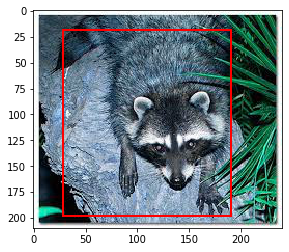

In [33]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
# Already done above

#from google.colab import drive
#drive.mount('/content/drive1')

#### Change your present working directory

In [0]:
# Already done above

#import os
#os.chdir('/content/drive1/My Drive/Colab Notebooks/Lab/Internal/Res9')

### Load your data file

In [0]:
mintmp_df = pd.read_csv('./daily-minimum-temperatures-in-me.csv')

#### Plot data

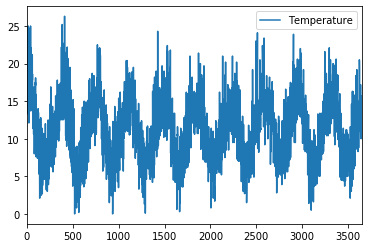

In [39]:
mintmp_df.plot()

#### Descibe your dataframe

In [40]:
mintmp_df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [41]:
mintmp_df.isnull().any()

Date           False
Temperature    False
dtype: bool

#### Drop null values

No Null values found.

In [0]:
# mintmp_df.dropna(inplace=True)

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f226645c780>]],
      dtype=object)

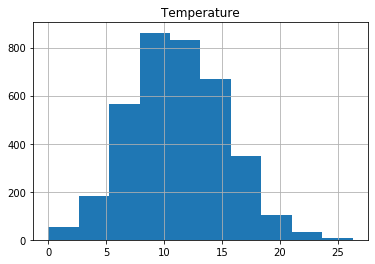

In [48]:
mintmp_df.hist(bins = 10)

#### Check the maximum and minimum values

In [49]:
print('Min Temoerature: ', min(mintmp_df['Temperature']))
print('Max temperature: ', max(mintmp_df['Temperature']))

Min Temoerature:  0.0
Max temperature:  26.3


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mintmp_df['Temperature'] = scaler.fit_transform(mintmp_df[['Temperature']])

#### Check the maximum and minimum values of scaled data

In [58]:
print('Min Temoerature: ', min(mintmp_df['Temperature']))
print('Max temperature: ', max(mintmp_df['Temperature']))

Min Temoerature:  0.0
Max temperature:  1.0


#### Look into some of the scaled values

In [59]:
dataset=np.array(mintmp_df['Temperature'].astype('float32')).reshape(len(mintmp_df),1)
print(dataset[:10])

[[0.78707224]
 [0.6806084 ]
 [0.7148289 ]
 [0.5551331 ]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159695]
 [0.82889736]
 [0.76045626]]


### Split data into Training and Testing

In [0]:
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size: len(dataset),:]

#### Print train and test size

In [61]:
print('Train data: ', train_size)
print('Train data: ', test_size)

Train data:  2555
Train data:  1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [63]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806084
1
X 1 to 2
[0.6806084]
Y 2
0.7148289
2
X 2 to 3
[0.7148289]
Y 3
0.5551331
3
X 3 to 4
[0.5551331]
Y 4
0.60076046
4
X 4 to 5
[0.60076046]
Y 5
0.60076046
5
X 5 to 6
[0.60076046]
Y 6
0.60076046
6
X 6 to 7
[0.60076046]
Y 7
0.66159695
7
X 7 to 8
[0.66159695]
Y 8
0.82889736
8
X 8 to 9
[0.82889736]
Y 9
0.76045626
9
X 9 to 10
[0.76045626]
Y 10
0.6159696
10
X 10 to 11
[0.6159696]
Y 11
0.50570345
11
X 11 to 12
[0.50570345]
Y 12
0.634981
12
X 12 to 13
[0.634981]
Y 13
0.8174905
13
X 13 to 14
[0.8174905]
Y 14
0.95057034
14
X 14 to 15
[0.95057034]
Y 15
0.78707224
15
X 15 to 16
[0.78707224]
Y 16
0.78326994
16
X 16 to 17
[0.78326994]
Y 17
0.9429658
17
X 17 to 18
[0.9429658]
Y 18
0.6730038
18
X 18 to 19
[0.6730038]
Y 19
0.5893536
19
X 19 to 20
[0.5893536]
Y 20
0.69201523
20
X 20 to 21
[0.69201523]
Y 21
0.46007603
21
X 21 to 22
[0.46007603]
Y 22
0.5475285
22
X 22 to 23
[0.5475285]
Y 23
0.608365
23
X 23 to 24
[0.608365]
Y 24
0.62737644
24
X 24 to 25
[0.62737644

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [64]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense

batch_size = 1
look_back=1
model = Sequential()
model.add(LSTM(6, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 6)                    192       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [67]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2553 samples, validate on 1093 samples
Epoch 1/20
 - 7s - loss: 0.0274 - val_loss: 0.0092
Epoch 2/20
 - 6s - loss: 0.0178 - val_loss: 0.0097
Epoch 3/20
 - 5s - loss: 0.0151 - val_loss: 0.0115
Epoch 4/20
 - 6s - loss: 0.0132 - val_loss: 0.0095
Epoch 5/20
 - 6s - loss: 0.0116 - val_loss: 0.0090
Epoch 6/20
 - 6s - loss: 0.0110 - val_loss: 0.0091
Epoch 7/20
 - 6s - loss: 0.0108 - val_loss: 0.0087
Epoch 8/20
 - 5s - loss: 0.0107 - val_loss: 0.0096
Epoch 9/20
 - 6s - loss: 0.0106 - val_loss: 0.0086
Epoch 10/20
 - 6s - loss: 0.0105 - val_loss: 0.0091
Epoch 11/20
 - 6s - loss: 0.0105 - val_loss: 0.0090
Epoch 12/20
 - 6s - loss: 0.0105 - val_loss: 0.0090
Epoch 13/20
 - 6s - loss: 0.0105 - val_loss: 0.0094
Epoch 14/20
 - 6s - loss: 0.0104 - val_loss: 0.0092
Epoch 15/20
 - 6s - loss: 0.0103 - val_loss: 0.0089
Epoch 16/20
 - 5s - loss: 0.0104 - val_loss: 0.0092
Epoch 17/20
 - 6s - loss: 0.0103 - 

## Make Predictions and Evaluate your model

In [69]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.48 RMSE


## Plot the results

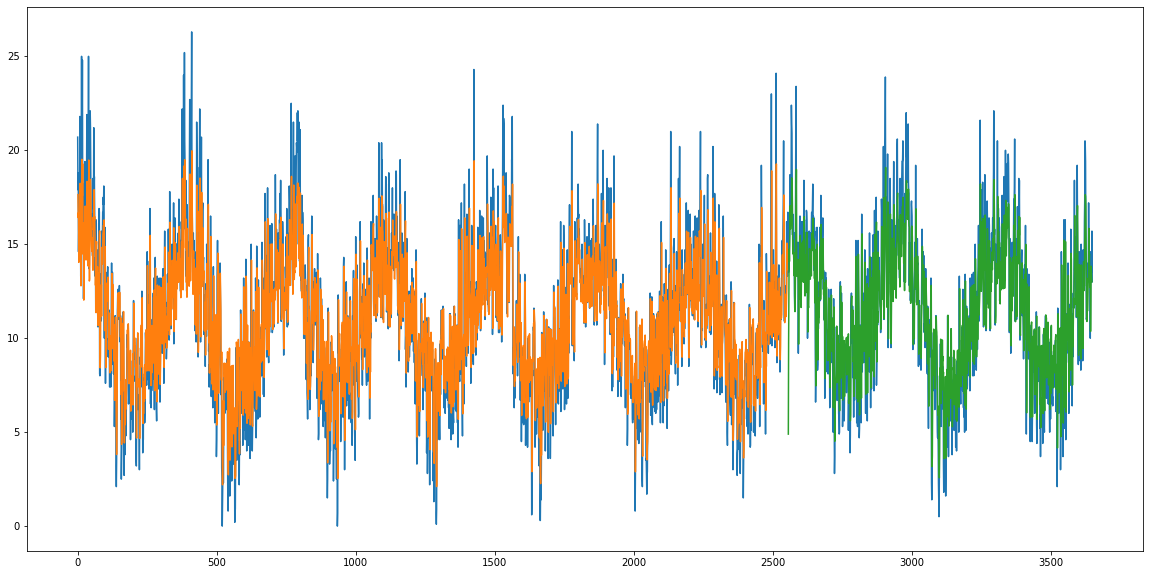

In [78]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()